## Module 5.5: Unsupervised Learning
- **Goal:** To find hidden patterns, structures, and relationships in data without a predefined target label (y).

In [1]:
import pandas as pd

url = "https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/8bd6144a87988213693754baaa13fb204933282d/Mall_Customers.csv"
df_to_save = pd.read_csv(url)
df_to_save.to_csv("mall_customers.csv", index=False)
print("'mall_customers.csv' created successfully.")

'mall_customers.csv' created successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

sns.set_theme(style="whitegrid")
df = pd.read_csv("mall_customers.csv")

## Topic 1: Clustering

The goal of clustering is to group a set of objects in such a way that objects in the same group (a cluster) are more similar to each other than to those in other groups.

### Data Preparation

Clustering algorithms are based on distance, so we must scale our numerical features.  
For this dataset, we'll focus on:

- **Age**
- **Annual Income (k$)**
- **Spending Score (1-100)**

In [2]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### A. K-Means Clustering

**Algorithm:**  
Iteratively assigns points to **K clusters** and updates the **cluster centroids**.

---

### 🔑 Key Topic: Initialization Challenges (The "Initialization Trap")

- **Problem:**  
  A poor random starting placement of centroids can lead to a **suboptimal clustering result** (a local minimum).

- **Solution:**  
  **K-Means++**:  
  Scikit-learn’s default `init='k-means++'` addresses this by **intelligently selecting initial centroids** that are far apart, leading to a much better start.  
  Also, `n_init='auto'` (default is 10) runs the algorithm multiple times with different starting points and **selects the best result**, making it more **robust**.

---

### 🔑 Key Topic: Choosing the Optimal Number of Clusters (K)

- **The Elbow Method:**  
  Plot **K vs. Inertia** (sum of squared distances to the centroid).  
  The **"elbow" point**, where the rate of decrease **slows significantly**, is a good candidate for **K**.


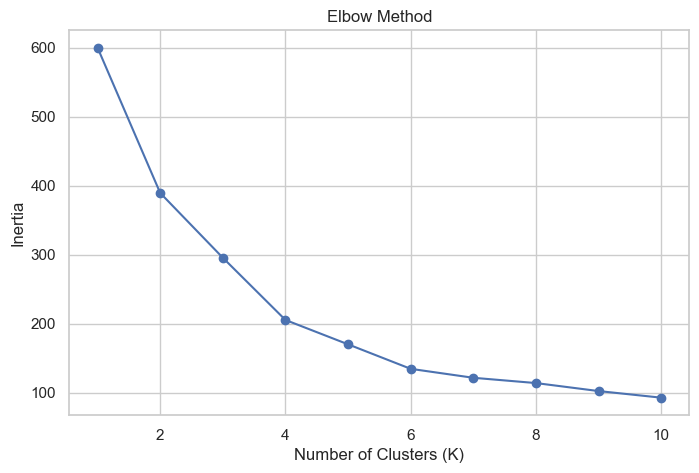

In [3]:
inertia_scores = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_scores, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()
# The elbow looks to be around K=5.

### 🔎 Silhouette Score

**Definition:**  
Measures how similar a data point is to its **own cluster** compared to **other clusters**.  
The score ranges from **-1 to 1**.

- **+1**: The point is very dense within its cluster and far from others.
- **0**: The point is on or very close to the decision boundary between two clusters.
- **-1**: The point may have been assigned to the wrong cluster.

**🎯 Goal:**  
Maximize the **average silhouette score** across all points.


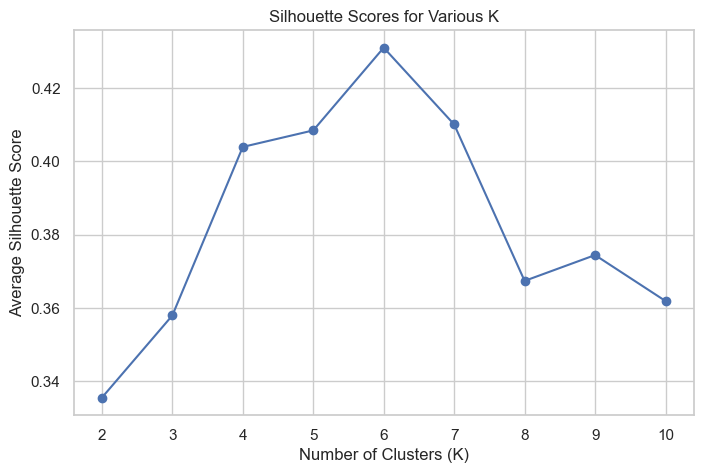

In [4]:
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.show()
# The peak is at K=5.

### 🧬 B. Hierarchical Clustering

#### 🔑 Key Topic: Agglomerative vs. Divisive

- **Agglomerative (Bottom-up):**  
  Starts with **N clusters** (each point is its own cluster) and **merges** them iteratively until only one cluster remains.  
  👉 This is the default approach used by **scikit-learn**.

- **Divisive (Top-down):**  
  Starts with **one large cluster** and **splits** it repeatedly until all points are in their own cluster.  
  ⚠️ Computationally expensive and less commonly used.

---

#### 🌳 Key Topic: Dendrograms

- A **tree diagram** that visualizes the cluster merging process.
- Helps choose **K** (the number of clusters) by identifying the **longest vertical lines** that can be "cut" across the diagram.


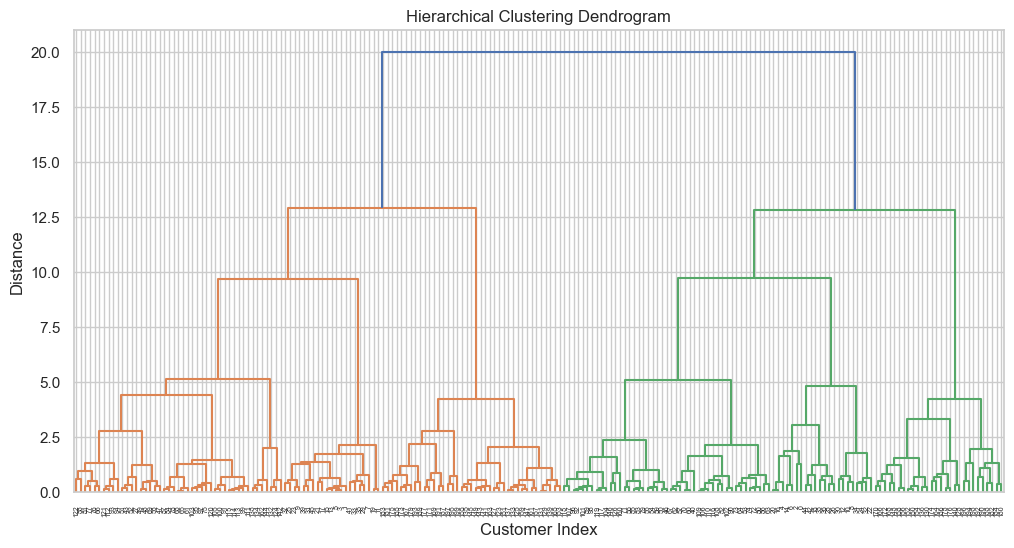


--- Data with Agglomerative Cluster Labels ---


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Agg_Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,0
2,3,Female,20,16,6,4
3,4,Female,23,16,77,0
4,5,Female,31,17,40,4


In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Visualizing with a Dendrogram ---
# 'ward' linkage minimizes the variance of the clusters being merged.
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           labels=df.index,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()
# We can see 5 clear color-coded groups if we "cut" the tree where the distances are large.

# --- Applying AgglomerativeClustering ---
agg_cluster = AgglomerativeClustering(n_clusters=5)
df['Agg_Cluster'] = agg_cluster.fit_predict(X_scaled)
print("\n--- Data with Agglomerative Cluster Labels ---")
display(df.head())

### 🌀 C. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

#### 📌 Algorithm
- Groups together points that are **closely packed** (i.e., have many nearby neighbors).
- Marks as **outliers** the points that lie alone in **low-density** regions.

---

#### ✅ Key Advantage
- **No need to specify the number of clusters** — it finds them **automatically** based on density.
- Excellent at identifying **noise/outliers**.

---

#### ⚙️ Parameters
- `eps`: The **maximum distance** between two samples for one to be considered in the neighborhood of the other.
- `min_samples`: The **minimum number of samples** in a neighborhood for a point to be considered a **core point**.


In [6]:
# --- Applying DBSCAN ---
# Finding the right eps and min_samples can be an iterative process.
dbscan = DBSCAN(eps=0.9, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
# Cluster label -1 indicates an outlier.

print("\n--- Data with DBSCAN Cluster Labels ---")
display(df['DBSCAN_Cluster'].value_counts())


--- Data with DBSCAN Cluster Labels ---


DBSCAN_Cluster
 0    197
-1      3
Name: count, dtype: int64

### 🧪 D. Key Topic: Evaluating Clustering (Internal Metrics)

When we **don't have ground truth labels**, we rely on **internal metrics** to evaluate the quality of clustering.

---

#### 📈 Silhouette Score (Recap)
- Measures how similar a data point is to its own cluster compared to other clusters.
- **Range:** -1 to 1  
  - **+1:** Well-clustered  
  - **0:** On the boundary between clusters  
  - **-1:** Possibly misclassified  
- **Goal:** Higher is better (closer to +1).

---

#### 📉 Davies-Bouldin Index
- Measures the **average similarity** between each cluster and its most similar cluster.
- Combines:
  - **Within-cluster scatter** (compactness)
  - **Between-cluster separation** (distance)
- **Range:** 0 to ∞  
- **Goal:** Lower is better  
  - A score of **0** is ideal, indicating **tight** and **well-separated** clusters.


In [7]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(X_scaled)
kmeans_labels = kmeans.labels_
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
print(f"K-Means (K=5) - Silhouette Score: {silhouette_avg:.4f} (Higher is better)")
print(f"K-Means (K=5) - Davies-Bouldin Index: {davies_bouldin:.4f} (Lower is better)")

K-Means (K=5) - Silhouette Score: 0.4085 (Higher is better)
K-Means (K=5) - Davies-Bouldin Index: 0.8890 (Lower is better)


## Topic 2: Dimensionality Reduction

### A. Principal Component Analysis (PCA)

**Concept ("Amaze Factor")**:  
PCA finds a new set of coordinates or *"components"* for the data. These components are **uncorrelated** and are ordered by the amount of **variance** they explain in the original data.  
- **PC1** (First Principal Component): Captures the **most variance**.  
- **PC2**: Captures the second-most variance and is **orthogonal to PC1**, and so on.

---

**Eigenvectors/Eigenvalues (Conceptual)**:  
- The *directions* of the new components are the **eigenvectors** of the **covariance matrix** of the data.  
- The *amount of variance* explained by each component is the **eigenvalue**.

---

### Use Cases:

- 🔉 **Noise Reduction**:  
  By keeping only the first few principal components, you can often remove random noise while preserving the main signal.

- 📈 **Visualization**:  
  Reduce high-dimensional data (e.g., 10 features) down to 2 or 3 principal components and plot them to understand the **structure** of the data.

- 🧠 **Feature Engineering**:  
  The new components can be used as **input features** for a supervised learning model to improve performance or reduce dimensionality.



--- Explained Variance Ratio ---
PC1 explains 44.27% of the variance.
PC2 explains 33.31% of the variance.
Total variance explained by 2 components: 77.57%


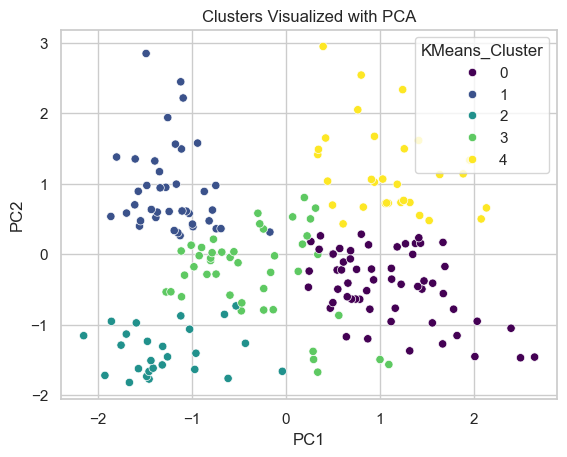

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("\n--- Explained Variance Ratio ---")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"Total variance explained by 2 components: {np.sum(pca.explained_variance_ratio_):.2%}")

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['KMeans_Cluster'] = kmeans_labels
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis').set_title('Clusters Visualized with PCA')
plt.show()

## B. t-SNE (t-distributed Stochastic Neighbor Embedding)

### 📌 Concept:
t-SNE is a **non-linear dimensionality reduction** technique used primarily for **visualizing high-dimensional data**. It works by modeling each high-dimensional object as a 2D or 3D point, such that:

- **Similar objects** are mapped to **nearby points**
- **Dissimilar objects** are mapped to **distant points**

This makes it an effective tool for understanding the **local structure** and clusters within complex datasets.

---

### 🔍 PCA vs. t-SNE

| Feature                    | PCA                                      | t-SNE                                         |
|---------------------------|------------------------------------------|-----------------------------------------------|
| Type                      | Linear                                   | Non-linear                                    |
| Focus                     | Preserves **global structure**           | Preserves **local structure**                 |
| Distance Interpretation   | Distances are meaningful globally        | Distances are **only meaningful locally**     |
| Use Case                  | Good for identifying large-scale patterns| Best for visualizing **clusters**             |

> ⚠️ **Note**: The distances between clusters in a t-SNE plot **are not meaningful**—only the relative placement of nearby points matters.


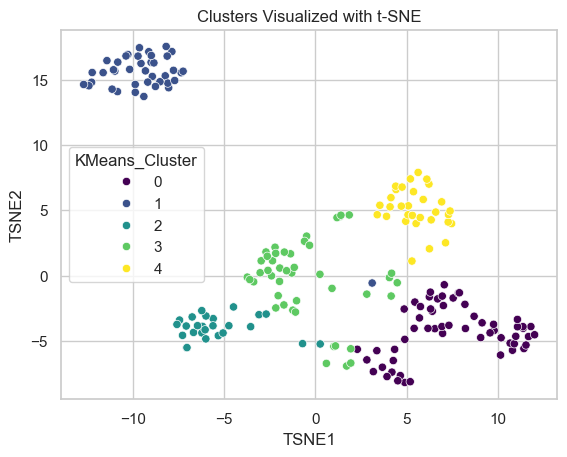

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['KMeans_Cluster'] = kmeans_labels
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette='viridis')
plt.title('Clusters Visualized with t-SNE')
plt.show()

- **UMAP** is another, often faster, alternative to t-SNE that is gaining popularity, but the concept is very similar.

## Topic 3: Association Rule Mining (Conceptual & Basic Implementation)

### 🛒 Concept: Market Basket Analysis
Association Rule Mining helps uncover patterns like:
> **{Diapers} → {Beer}**  
Meaning: Customers who buy diapers also tend to buy beer.

This is especially useful in **retail** and **e-commerce** for understanding buying behavior and product bundling.

---

### 📊 Key Metrics

- **Support**:  
  Frequency of an itemset in the dataset.  
  \[
  \text{Support}(A) = \frac{\text{Transactions containing } A}{\text{Total transactions}}
  \]

- **Confidence**:  
  How often items in B appear in transactions that contain A.  
  \[
  \text{Confidence}(A → B) = \frac{\text{Support}(A ∪ B)}{\text{Support}(A)}
  \]

- **Lift**:  
  Measures how much more often A and B occur together than expected if they were independent.  
  \[
  \text{Lift}(A → B) = \frac{\text{Confidence}(A → B)}{\text{Support}(B)}
  \]

---

### ⚙️ Algorithms
- **Apriori**: Iteratively finds frequent itemsets using a bottom-up approach.
- **FP-Growth**: Faster alternative to Apriori using a prefix tree structure.

In [10]:
# Create a sample transaction dataset
transactions = [['beer', 'diapers', 'bread', 'milk'],
                ['beer', 'diapers', 'bread', 'chips'],
                ['beer', 'diapers', 'soda'],
                ['bread', 'milk', 'chips'],
                ['beer', 'bread', 'milk'],
                ['diapers', 'bread', 'milk', 'soda']]

**Basic Implementation with mlxtend:**

In [11]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Transform the data into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

print("--- One-Hot Encoded Transactions ---")
display(df_trans)

# 2. Run the Apriori algorithm to find frequent itemsets
# min_support=0.5 means we only care about itemsets that appear in at least 50% of transactions
frequent_itemsets = apriori(df_trans, min_support=0.5, use_colnames=True)
print("\n--- Frequent Itemsets (Support >= 0.5) ---")
display(frequent_itemsets)

# 3. Generate the association rules
# min_threshold=0.7 for confidence
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print("\n--- Association Rules (Confidence >= 0.7) ---")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
# The rule {diapers} -> {beer} has a confidence of 0.75 and a lift of 0.9, meaning they are slightly negatively correlated in this tiny dataset.

--- One-Hot Encoded Transactions ---


,beer,bread,chips,diapers,milk,soda
0,True,True,False,True,True,False
1,True,True,True,True,False,False
2,True,False,False,True,False,True
3,False,True,True,False,True,False
4,True,True,False,False,True,False
5,False,True,False,True,True,True



--- Frequent Itemsets (Support >= 0.5) ---


,support,itemsets
0,0.666667,(beer)
1,0.833333,(bread)
2,0.666667,(diapers)
3,0.666667,(milk)
4,0.500000,"(beer, bread)"
5,0.500000,"(beer, diapers)"
6,0.500000,"(bread, diapers)"
7,0.666667,"(bread, milk)"



--- Association Rules (Confidence >= 0.7) ---


,antecedents,consequents,support,confidence,lift
0,(beer),(bread),0.500000,0.75,0.900
1,(beer),(diapers),0.500000,0.75,1.125
2,(diapers),(beer),0.500000,0.75,1.125
3,(diapers),(bread),0.500000,0.75,0.900
4,(bread),(milk),0.666667,0.80,1.200
5,(milk),(bread),0.666667,1.00,1.200


## Mini-Project: Customer Segmentation
- **Goal:** Using the mall_customers.csv dataset, apply clustering and PCA to segment customers and analyze the resulting groups.

1. **Data Prep & Choosing K (Already Done!):** You've determined K=5 is optimal.
2. **Run Final K-Means Model:** Run K-Means with n_clusters=5 and add the labels back to your original df.
3. **Visualize with PCA (Already Done!):** You have your 2D scatter plot of the clusters.
4. **Segment Analysis & Interpretation ("Amaze Factor"):**
    - Use .groupby('Cluster_Label') on your df to calculate the mean values of Age, Annual Income (k$), and Spending Score (1-100) for each of the 5 clusters.
    - Create a pairplot of the original data, colored by the cluster labels (sns.pairplot(df, hue='Cluster_Label', vars=features)).
    - In a Markdown cell, create "personas" for each cluster. Describe each segment in plain English based on your findings (e.g., "High Income, Low Spenders", "Young, High Spenders", etc.).

In [13]:
# Run K-Means with K = 5
final_kmeans = KMeans(n_clusters = 5, random_state=5, n_init = 'auto')
final_kmeans.fit(X_scaled)

# 2. Add the cluster labels to the original dataframe
df['cluster_label'] = final_kmeans.labels_
print("Successfully added 'Cluster_Label' column to the dataframe.")
display(df.head())

Successfully added 'Cluster_Label' column to the dataframe.


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Agg_Cluster,DBSCAN_Cluster,cluster_label
0,1,Male,19,15,39,4,0,1
1,2,Male,21,15,81,0,0,1
2,3,Female,20,16,6,4,-1,0
3,4,Female,23,16,77,0,0,1
4,5,Female,31,17,40,4,0,1


In [15]:
# Group by the new cluster label and calculate the mean for each feature
segment_analysis = df.groupby(['cluster_label'])[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

print("--- Mean Characteristics of Each Customer Segment ---")
display(segment_analysis)

--- Mean Characteristics of Each Customer Segment ---


,Age,Annual Income (k$),Spending Score (1-100)
cluster_label,,,
0,46.250000,26.750000,18.350000
1,25.185185,41.092593,62.240741
2,39.871795,86.102564,19.358974
3,55.638298,54.382979,48.851064
4,32.875000,86.100000,81.525000


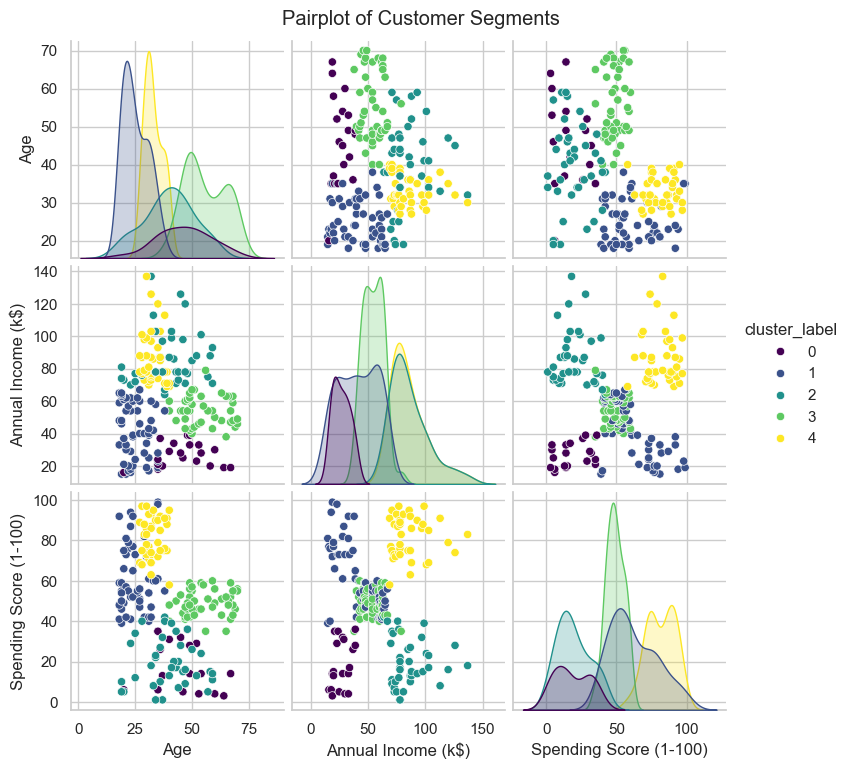

In [17]:
# Create a pairplot to visualize the relationships, colored by cluster
sns.pairplot(df, 
             hue='cluster_label', 
             vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
             palette='viridis')
plt.suptitle('Pairplot of Customer Segments', y=1.02) # Adjust title position
plt.show()

### Customer Segment Personas

#### Cluster 0: The Frugal Shoppers 🧾

- **Characteristics**:  
  - Older (Avg. Age: ~46)  
  - Low Income (Avg: ~$27k)  
  - Low Spending Score (Avg: ~18)

- **Interpretation**:  
  This group is cautious with their money. They have low income and do not spend much at the mall. They are likely looking for discounts and essential items only.

---

#### Cluster 1: Young & Eager 🛍️

- **Characteristics**:  
  - Young (Avg. Age: ~25)  
  - Low-to-Mid Income (Avg: ~$41k)  
  - High Spending Score (Avg: ~62)

- **Interpretation**:  
  These are likely students or young professionals who enjoy shopping and keeping up with trends. They spend a significant portion of their moderate income, making them a key target for fast-fashion and entertainment.

---

#### Cluster 2: The Cautious Wealthy 🧐

- **Characteristics**:  
  - Middle-Aged (Avg. Age: ~40)  
  - High Income (Avg: ~$86k)  
  - Low Spending Score (Avg: ~19)

- **Interpretation**:  
  This segment has high purchasing power but is extremely selective and doesn't spend freely. They value saving and might only purchase high-value items after careful consideration. They are a difficult but potentially rewarding target for luxury brands.

---

#### Cluster 3: The Average Older Customer 😐

- **Characteristics**:  
  - Older (Avg. Age: ~56)  
  - Average Income (Avg: ~$54k)  
  - Average Spending Score (Avg: ~49)

- **Interpretation**:  
  This group represents the standard, middle-of-the-road, and established shopper. Their habits are moderate and predictable, forming the stable base of the mall's clientele.

---

#### Cluster 4: The Prime Target 🎯

- **Characteristics**:  
  - Prime Spending Age (Avg. Age: ~33)  
  - High Income (Avg: ~$86k)  
  - High Spending Score (Avg: ~82)

- **Interpretation**:  
  This is the mall's most valuable segment. They have high income and a strong willingness to spend. They are the primary target for new arrivals, premium products, and loyalty programs.